## Day 14: Regolith Reservoir

The distress signal leads you to a giant waterfall! Actually, hang on - the signal seems like it's coming from the waterfall itself, and that doesn't make any sense. However, you do notice a little path that leads behind the waterfall.

Correction: the distress signal leads you behind a giant waterfall! There seems to be a large cave system here, and the signal definitely leads further inside.

As you begin to make your way deeper underground, you feel the ground rumble for a moment. Sand begins pouring into the cave! If you don't quickly figure out where the sand is going, you could quickly become trapped!

Fortunately, your familiarity with analyzing the path of falling material will come in handy here. You scan a two-dimensional vertical slice of the cave above you (your puzzle input) and discover that it is mostly air with structures made of rock.

Your scan traces the path of each solid rock structure and reports the x,y coordinates that form the shape of the path, where x represents distance to the right and y represents distance down. Each path appears as a single line of text in your scan. After the first point of each path, each point indicates the end of a straight horizontal or vertical line to be drawn from the previous point. For example:

```
498,4 -> 498,6 -> 496,6
503,4 -> 502,4 -> 502,9 -> 494,9
```

In [1]:
import pytest
from icecream import ic
from vectors import Vector

In [2]:
def load_input(filename):
    with open(filename, 'r') as f_input:
        for line in f_input:
            yield [
                Vector(*[int(num) for num in point.split(',')])
                for point in line.split(' -> ')
            ]
            
for points in load_input('sample.txt'):
    print(' -> '.join(
        f'{point.x},{point.y}'
        for point in points
    ))

498,4 -> 498,6 -> 496,6
503,4 -> 502,4 -> 502,9 -> 494,9


In [3]:
import itertools
import collections

def fill(a, b):
    if a < b:
        return list(range(a, b))
    elif a > b:
        return list(range(a, b, -1))
    return [a]

assert ic(fill(3, 7)) == [3, 4, 5, 6]
assert ic(fill(7, 3)) == [7, 6, 5, 4]

ic| fill(3, 7): [3, 4, 5, 6]
ic| fill(7, 3): [7, 6, 5, 4]


In [4]:
def load_map(iterable):
    all_x = set([500])
    all_y = set([0])
    bit_map = collections.defaultdict(lambda: '.')
    bit_map[500, 0] = '+'
    for points in iter(iterable):
        for (start, end) in itertools.pairwise(points):
            all_x.add(start.x)
            all_x.add(end.x)
            all_y.add(start.y)
            all_y.add(end.y)
            if start.y == end.y:  # Horizontal line
                for _x in fill(start.x, end.x):
                    bit_map[_x, start.y] = '#'
            elif start.x == end.x:  # Vertical line
                for _y in fill(start.y, end.y):
                    bit_map[start.x, _y] = '#'
        bit_map[end.x, end.y] = '#'
        all_y.add(end.y)
    min_point = Vector(min(all_x), min(all_y))
    max_point = Vector(max(all_x), max(all_y))
    return bit_map, min_point, max_point


bit_map, min_point, max_point = load_map(load_input('sample.txt'))

bit_map, min_point, max_point

(defaultdict(<function __main__.load_map.<locals>.<lambda>()>,
             {(500, 0): '+',
              (498, 4): '#',
              (498, 5): '#',
              (498, 6): '#',
              (497, 6): '#',
              (496, 6): '#',
              (503, 4): '#',
              (502, 4): '#',
              (502, 5): '#',
              (502, 6): '#',
              (502, 7): '#',
              (502, 8): '#',
              (502, 9): '#',
              (501, 9): '#',
              (500, 9): '#',
              (499, 9): '#',
              (498, 9): '#',
              (497, 9): '#',
              (496, 9): '#',
              (495, 9): '#',
              (494, 9): '#'}),
 Vector(x=494, y=0),
 Vector(x=503, y=9))


This scan means that there are two paths of rock; the first path consists of two straight lines, and the second path consists of three straight lines. (Specifically, the first path consists of a line of rock from 498,4 through 498,6 and another line of rock from 498,6 through 496,6.)

The sand is pouring into the cave from point $500,0$.

Drawing rock as #, air as ., and the source of the sand as +, this becomes:

```
  4     5  5
  9     0  0
  4     0  3
0 ......+...
1 ..........
2 ..........
3 ..........
4 ....#...##
5 ....#...#.
6 ..###...#.
7 ........#.
8 ........#.
9 #########.
```

In [5]:
def show_bitmap(bit_map, min_point, max_point):
    for y in range(min_point.y, max_point.y + 1):
        for x in range(min_point.x, max_point.x + 1):
            char = bit_map[x, y]
            print(char, end='')
        print()
        
bitmap, min_point, max_point = load_map(load_input('sample.txt'))
show_bitmap(bitmap, min_point, max_point)

......+...
..........
..........
..........
....#...##
....#...#.
..###...#.
........#.
........#.
#########.


Sand is produced one unit at a time, and the next unit of sand is not produced until the previous unit of sand comes to rest. A unit of sand is large enough to fill one tile of air in your scan.

A unit of sand always falls down one step if possible. If the tile immediately below is blocked (by rock or sand), the unit of sand attempts to instead move diagonally one step down and to the left. If that tile is blocked, the unit of sand attempts to instead move diagonally one step down and to the right. Sand keeps moving as long as it is able to do so, at each step trying to move down, then down-left, then down-right. If all three possible destinations are blocked, the unit of sand comes to rest and no longer moves, at which point the next unit of sand is created back at the source.

So, drawing sand that has come to rest as o, the first unit of sand simply falls straight down and then stops:

```
......+...
..........
..........
..........
....#...##
....#...#.
..###...#.
........#.
......o.#.
#########.
```

In [6]:
def add_sand(bit_map, limit):
    x = 500; y = 0
    while True:
        if y > limit:
            return None
        if bit_map[x, y+1] == '.':
            y = y + 1
            continue
        if bit_map[x-1, y+1] == '.':
            x = x - 1
            y = y + 1
            continue
        elif bit_map[x+1, y+1] == '.':
            x = x + 1
            y = y + 1
            continue
        break
    return (x, y)

bit_map, min_point, max_point = load_map(load_input('sample.txt'))
new_point = add_sand(bit_map, max_point.y)
bit_map[new_point] = 'o'
show_bitmap(bit_map, min_point, max_point)


......+...
..........
..........
..........
....#...##
....#...#.
..###...#.
........#.
......o.#.
#########.


The second unit of sand then falls straight down, lands on the first one, and then comes to rest to its left:

```
......+...
..........
..........
..........
....#...##
....#...#.
..###...#.
........#.
.....oo.#.
#########.
```

In [7]:
bit_map, min_point, max_point = load_map(load_input('sample.txt'))
new_point = add_sand(bit_map, max_point.y)
bit_map[new_point] = 'o'
new_point = add_sand(bit_map, max_point.y)
bit_map[new_point] = 'o'
show_bitmap(bit_map, min_point, max_point)


......+...
..........
..........
..........
....#...##
....#...#.
..###...#.
........#.
.....oo.#.
#########.


After a total of five units of sand have come to rest, they form this pattern:

```
......+...
..........
..........
..........
....#...##
....#...#.
..###...#.
......o.#.
....oooo#.
#########.
```

In [8]:
bit_map, min_point, max_point = load_map(load_input('sample.txt'))
for _ in range(5):
    new_point = add_sand(bit_map, max_point.y)
    bit_map[new_point] = 'o'
show_bitmap(bit_map, min_point, max_point)

......+...
..........
..........
..........
....#...##
....#...#.
..###...#.
......o.#.
....oooo#.
#########.


After a total of 22 units of sand:

```
......+...
..........
......o...
.....ooo..
....#ooo##
....#ooo#.
..###ooo#.
....oooo#.
...ooooo#.
#########.
```

In [9]:
bit_map, min_point, max_point = load_map(load_input('sample.txt'))
for _ in range(22):
    new_point = add_sand(bit_map, max_point.y)
    bit_map[new_point] = 'o'
show_bitmap(bit_map, min_point, max_point)

......+...
..........
......o...
.....ooo..
....#ooo##
....#ooo#.
..###ooo#.
....oooo#.
...ooooo#.
#########.


Finally, only two more units of sand can possibly come to rest:

```
......+...
..........
......o...
.....ooo..
....#ooo##
...o#ooo#.
..###ooo#.
....oooo#.
.o.ooooo#.
#########.
```

In [10]:
bit_map, min_point, max_point = load_map(load_input('sample.txt'))
for _ in range(24):
    new_point = add_sand(bit_map, max_point.y)
    bit_map[new_point] = 'o'
show_bitmap(bit_map, min_point, max_point)

......+...
..........
......o...
.....ooo..
....#ooo##
...o#ooo#.
..###ooo#.
....oooo#.
.o.ooooo#.
#########.


Once all 24 units of sand shown above have come to rest, all further sand flows out the bottom, falling into the endless void. Just for fun, the path any new sand takes before falling forever is shown here with ~:

```
.......+...
.......~...
......~o...
.....~ooo..
....~#ooo##
...~o#ooo#.
..~###ooo#.
..~..oooo#.
.~o.ooooo#.
~#########.
~..........
~..........
~..........
```

In [11]:
bit_map, min_point, max_point = load_map(load_input('sample.txt'))
for _ in range(24):
    new_point = add_sand(bit_map, max_point.y)
    bit_map[new_point] = 'o'
assert add_sand(bit_map, max_point.y) is None

Using your scan, simulate the falling sand. How many units of sand come to rest before sand starts flowing into the abyss below?

In [12]:
def solution_one(filename):
    bit_map, min_point, max_point = load_map(load_input(filename))
    count = 0 
    new_point = add_sand(bit_map, max_point.y)
    while new_point is not None:
        bit_map[new_point] = 'o'
        count += 1
        new_point = add_sand(bit_map, max_point.y)
    return count
    
assert ic(solution_one('sample.txt')) == 24

ic| solution_one('sample.txt'): 24


In [13]:
sol = solution_one('input.txt')
print(f"Solution part one: {sol}")

Solution part one: 808


## Part two

You realize you misread the scan. There isn't an endless void at the bottom of the scan - there's floor, and you're standing on it!

You don't have time to scan the floor, so assume the floor is an infinite horizontal line with a y coordinate equal to two plus the highest y coordinate of any point in your scan.

In the example above, the highest y coordinate of any point is 9, and so the floor is at y=11. (This is as if your scan contained one extra rock path like -infinity,11 -> infinity,11.) With the added floor, the example above now looks like this:

```
        ...........+........
        ....................
        ....................
        ....................
        .........#...##.....
        .........#...#......
        .......###...#......
        .............#......
        .............#......
        .....#########......
        ....................
<-- etc #################### etc -->
```

To find somewhere safe to stand, you'll need to simulate falling sand until a unit of sand comes to rest at 500,0, blocking the source entirely and stopping the flow of sand into the cave. In the example above, the situation finally looks like this after 93 units of sand come to rest:

```
............o............
...........ooo...........
..........ooooo..........
.........ooooooo.........
........oo#ooo##o........
.......ooo#ooo#ooo.......
......oo###ooo#oooo......
.....oooo.oooo#ooooo.....
....oooooooooo#oooooo....
...ooo#########ooooooo...
..ooooo.......ooooooooo..
#########################
```

In [14]:
def add_sand_two(bit_map, limit):
    x = 500; y = 0
    while True:
        if y > limit:
            bit_map[x, y] = 'o'
            bit_map[x, y+1] = '#'
            return (x, y)
        if bit_map[x, y+1] == '.':
            y = y + 1
            continue
        if bit_map[x-1, y+1] == '.':
            x = x - 1
            y = y + 1
            continue
        elif bit_map[x+1, y+1] == '.':
            x = x + 1
            y = y + 1
            continue
        break
    return (x, y)

bit_map, min_point, max_point = load_map(load_input('sample.txt'))
max_point = Vector(max_point.x, max_point.y + 2)
limit = max_point.y - 1
for _ in range(133):
    (x, y) = add_sand_two(bit_map, limit=limit-1)
    if min_point.x > x:
        min_point = Vector(x, min_point.y)
    if max_point.x < x:
        max_point = Vector(x, max_point.y)
    bit_map[x, y] = 'o'
show_bitmap(bit_map, min_point, max_point)
ic(x, y)

ic| x: 500, y: 0


..........o..........
.........ooo.........
........ooooo........
.......ooooooo.......
......oo#ooo##o......
.....ooo#ooo#ooo.....
....oo###ooo#oooo....
...oooo.oooo#ooooo...
..oooooooooo#oooooo..
.ooo#########ooooooo.
ooooo.......ooooooooo
#####.......#########


(500, 0)

Using your scan, simulate the falling sand until the source of the sand becomes blocked. How many units of sand come to rest?

In [15]:
def solution_two(filename):
    bit_map, min_point, max_point = load_map(load_input(filename))
    max_point = Vector(max_point.x, max_point.y + 2)
    limit = max_point.y - 1
    count = 0
    while True:
        (x, y) = add_sand_two(bit_map, limit=limit - 1)
        count += 1
        if x == 500 and y == 0:
            # show_bitmap(bit_map, min_point, max_point)
            return count
        if min_point.x > x:
            min_point = Vector(x, min_point.y)
        if max_point.x < x:
            max_point = Vector(x, max_point.y)
        bit_map[x, y] = 'o'

In [16]:
solution_two('sample.txt')

93

In [17]:
sol = solution_two('input.txt')
print(f"Solution part teo: {sol}")

Solution part teo: 26625


## Extra

In [18]:
def solution_g(filename):
    bit_map, min_point, max_point = load_map(load_input(filename))
    max_point = Vector(max_point.x, max_point.y + 2)
    limit = max_point.y - 1
    while True:
        (x, y) = add_sand_two(bit_map, limit=limit-1)
        if x == 500 and y == 0:
            # show_bitmap(bit_map, min_point, max_point)
            return bit_map, min_point, max_point
        if min_point.x > x:
            min_point = Vector(x, min_point.y)
        if max_point.x < x:
            max_point = Vector(x, max_point.y)
        bit_map[x, y] = 'o'

ic| width: 24, height: 15


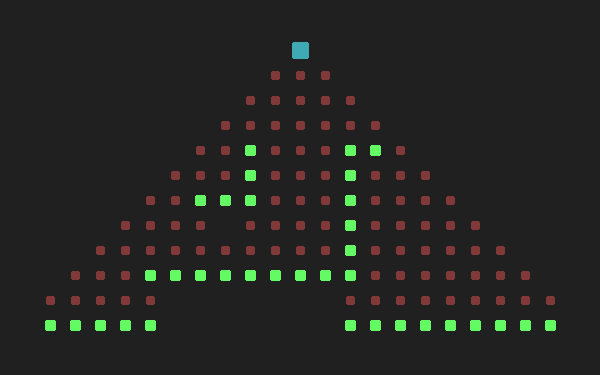

In [19]:
from show import Grid, GREEN

bit_map, min_point, max_point =  solution_g('sample.txt')
width = max_point.x - min_point.x + 4
height = max_point.y - min_point.y + 4
offset = Vector(min_point.x - 2, min_point.y - 2)
ic(width, height)

SCALE = 25
g = Grid(width, height, scale=SCALE)

for y in range(min_point.y-2, max_point.y+1):
    for x in range(min_point.x-2, max_point.x+1):
        char = bit_map[x, y]
        if x == 500 and y == 0:
            p = Vector(x, y) - offset
            g.box(p*SCALE, size=16, color=(63, 170,180))
        elif char == '#':
            p = Vector(x, y) - offset
            g.box(p*SCALE, size=10, color=GREEN)
        elif char == 'o':
            p = Vector(x, y) - offset
            g.box(p*SCALE, size=9, color=(129, 56, 56))
            
g.img.save('sample.png')            
g.img

ic| width: 336, height: 171


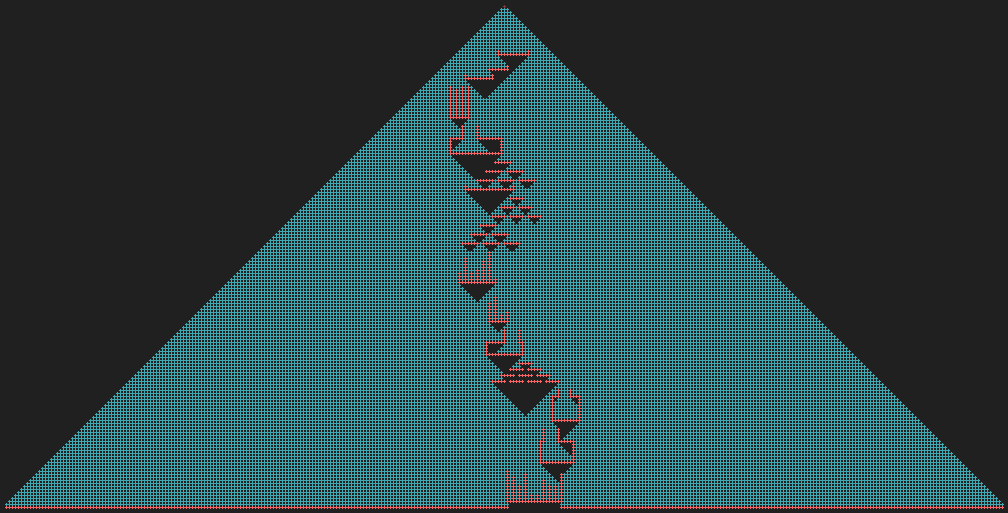

In [20]:
from show import Grid, RED

bit_map, min_point, max_point =  solution_g('input.txt')
width = max_point.x - min_point.x + 4
height = max_point.y - min_point.y + 4
offset = Vector(min_point.x - 2, min_point.y - 2)
ic(width, height)

SCALE = 3
g = Grid(width, height, scale=SCALE)

for y in range(min_point.y-2, max_point.y+1):
    for x in range(min_point.x-2, max_point.x+1):
        char = bit_map[x, y]
        if x == 500 and y == 0:
            p = Vector(x, y) - offset
            g.box(p*SCALE, size=2, color=(129, 56, 56))
        elif char == '#':
            p = Vector(x, y) - offset
            g.box(p*SCALE, size=2, color=RED)
        elif char == 'o':
            p = Vector(x, y) - offset
            g.box(p*SCALE, size=2, color=(63, 170,180))
            
g.img.save('input.png')
g.img